# 3D convolution fit

In [1]:
import os
import itertools
import numpy as np
from scipy import stats, signal
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import sys
sys.path.append('../')

In [3]:
from lib.dndnpip import DnDnPip
from lib import resolution as res
from lib.params import mdn, mpip, mdstp
from lib.dalitzphsp import Kibble
from lib.convolution import local_resolution_grid, smeared_pdf
from lib.vartools import generated_to_observables, observables_to_mandelstam
from lib.plots import draw_1d_projections, draw_pdf_projections

In [13]:
gr = np.random.Generator(np.random.PCG64())

In [15]:
data = np.linspace(0, 1, 100)
sigmas = gr.normal(1., 0.05, 100)
sigmas.shape

(100,)

In [18]:
reso = stats.norm.pdf(data, 0., sigmas)
N = 11
reso[N], stats.norm.pdf(data[N], 0., sigmas[N])

(0.37060320826356197, 0.37060320826356197)

In [4]:
path_data = '../mcsamples'

In [5]:
def sample_fname(re, im ,ch):
    """ Smeared toy MC data set file name """
    fname = os.path.join(path_data, f'mc_ddpip_3d_gs{re:.2f}_{im:.2f}_ch{ch}_smeared.npy')
    if os.path.isfile(fname):
        return fname
    print(f'file {fname} not found')
    return None

def get_sample(re, im, ch, nevt):
    """ Load smeared toy MC data set """
    fname = sample_fname(re, im, ch)
    if fname:
        data = np.load(fname)[:nevt]
        return (data[:, 0], *generated_to_observables(data[:, 1], data[:, 2]))
    else:
        return None

In [8]:
e, pd, mdpi = get_sample(40, 1.5, 10, 5000)

In [9]:
def get_labels():
    return (r'$E (MeV)$', r'$p(D^0)$ (MeV)', r'$m(D^0pi^+)$ (MeV)')

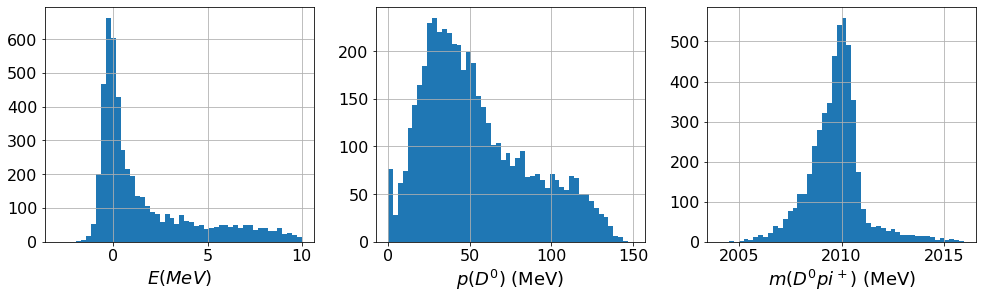

In [12]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4.5))
draw_1d_projections(ax, e, pd, mdpi, bins=50)
fig.tight_layout()

## Convolution test

In [7]:
N = 100
x, y, z = [np.linspace(-5, 5, N) for _ in range(3)]
dr = (x[1] - x[0])**3
grid_3d = np.array(list(itertools.product(x, y, z))).reshape(N, N, N, 3)
grid_3d.shape

(100, 100, 100, 3)

In [8]:
def pdf(x, y, z):
    return stats.norm.pdf(x, 0, 1) * stats.norm.pdf(y, 0, 1) * stats.norm.pdf(z, 0, 1)

In [9]:
f1 = pdf(grid_3d[:,:,:,0], grid_3d[:,:,:,1], grid_3d[:,:,:,2]).reshape(N,N,N,1)
f1.shape

(100, 100, 100, 1)

In [10]:
self_conv = signal.fftconvolve(f1, f1, 'same')*dr
self_conv.shape

(100, 100, 100, 1)

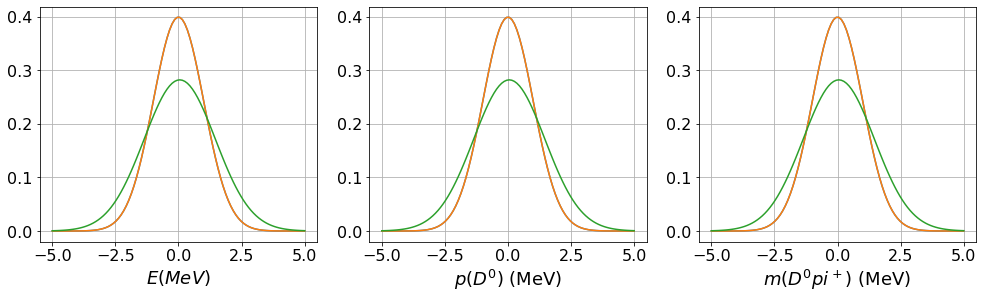

In [11]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4.5))
draw_pdf_projections(ax, [x, y, z], f1)
draw_pdf_projections(ax, [x, y, z], f1)
draw_pdf_projections(ax, [x, y, z], self_conv)
fig.tight_layout()

Energy resolution contours

/home/vitaly/miniconda3/envs/tf2/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


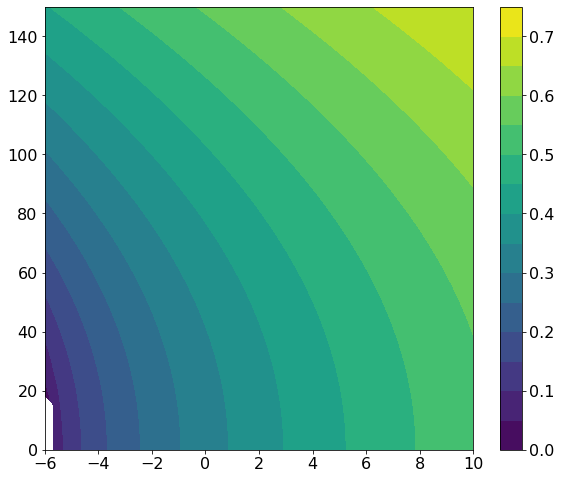

In [12]:
fig, ax = plt.subplots(figsize=(8.5, 7))
vg = np.meshgrid(np.linspace(-6, 10, 50), np.linspace(0, 150, 50))
cf = ax.contourf(*vg, res.get_resolution(*vg)[0], levels=15)
fig.colorbar(cf)
fig.tight_layout()

In [13]:
e0, pd0, mdpi0, ndots = e[0], pd[0], mdpi[0], 101
e0, pd0, mdpi0

(3.0092793, 58.806427, 2012.3253)

In [14]:
x_full, x_full_grid, x_reso, x_reso_grid, reso, dr = local_resolution_grid(e0, pd0, mdpi0, ndots, 7, 5)
len(x_full), x_full_grid.shape, len(x_reso), x_reso_grid.shape, reso.shape

(3, (1030301, 3), 3, (373248, 3), (373248,))

In [15]:
ndots_res = int(np.cbrt(x_reso_grid.shape[0]))
ndots_res

72

In [16]:
x_full_grid[0, :], x_full_grid[-1, :]

(array([-6.30450249e-02,  1.82184982e+01,  2.00980664e+03]),
 array([   6.08160353,   99.39435577, 2014.84399414]))

In [17]:
x_reso_grid[0, :], x_reso_grid[-1, :], np.cbrt(x_reso_grid.shape[0])

(array([ -2.19451714, -28.99137688,  -1.79906356]),
 array([ 2.16817927, 28.64344406,  1.77745879]),
 72.00000000000001)

In [18]:
x_reso[0].size, x_reso[1].size, x_reso[2].size

(72, 72, 72)

In [19]:
pdf = DnDnPip(41, 1.5)

In [20]:
x_full_grid.shape

(1030301, 3)

In [21]:
pdfval = pdf.pdf_vars(x_full_grid[:, 0], x_full_grid[:, 1], x_full_grid[:, 2]).reshape(ndots, ndots, ndots, 1)
pdfval.shape

(101, 101, 101, 1)

In [22]:
reso = reso.reshape(ndots_res, ndots_res, ndots_res, 1)
reso.shape

(72, 72, 72, 1)

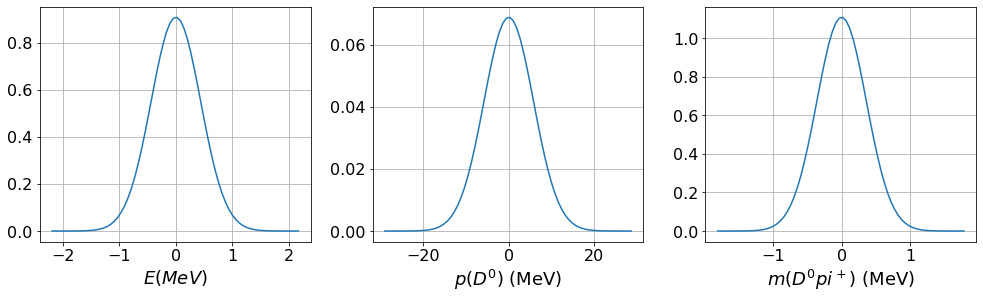

In [23]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4.5))
draw_pdf_projections(ax, x_reso, reso)
fig.tight_layout()

In [24]:
pdfconv = signal.fftconvolve(pdfval, reso, 'same') * dr

In [25]:
print(f'{pdfval.sum()} -> {pdfconv.sum()} ({pdfval.sum() / pdfconv.sum():.2f})')

602937.8102080304 -> 525895.8273074959 (1.15)


In [26]:
idx = (ndots + 1) // 2
print(f'{pdfval[idx, idx, idx]} -> {pdfconv[idx, idx, idx]}')

[2.76591743] -> [1.60878165]


In [27]:
pdfval.shape, pdfconv.shape

((101, 101, 101, 1), (101, 101, 101, 1))

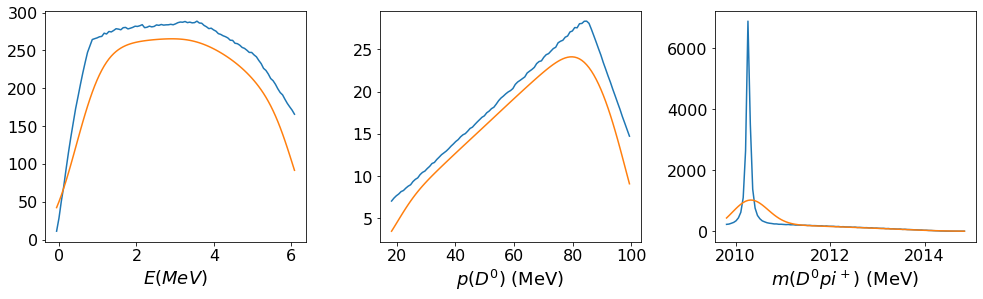

In [28]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4.5))
draw_pdf_projections(ax, x_full, pdfval)
draw_pdf_projections(ax, x_full, pdfconv)
fig.tight_layout()

In [35]:
N = 20
x, y, z = [np.linspace(item.min(), item.max(), N) for item in [e, pd, mdpi]]
spdf = np.empty((N,N,N))
spdf.shape

(20, 20, 20)

In [36]:
pdf = DnDnPip(41, 1.5)

In [37]:
%%time
spdf = [smeared_pdf(pdf, a, b, c, 11) for a,b,c in itertools.product(x, y, z)]
len(spdf)

CPU times: user 1min 44s, sys: 11.2 s, total: 1min 55s
Wall time: 1min 31s


8000

In [38]:
sspdf = np.array(spdf).reshape(N,N,N,1)

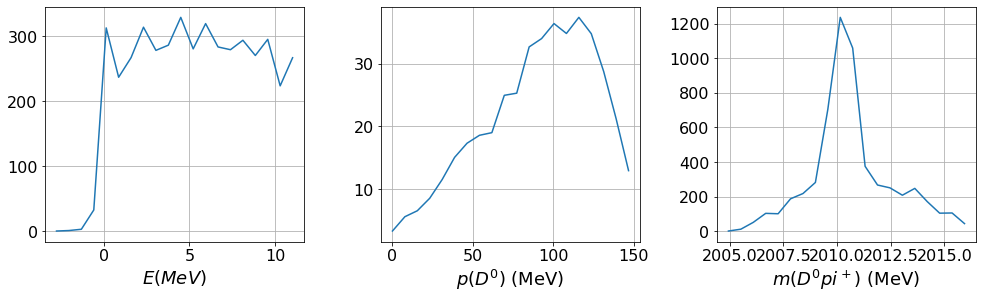

In [39]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4.5))
draw_pdf_projections(ax, [x, y, z], sspdf)
fig.tight_layout()